In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import mean_squared_error

In [3]:
# # Import everything from glucose_transformer
# %cd /content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/glucose_transformer.py
# import glucose_transformer

# from glucose_transformer import (
#     TimeSeriesDataset,
#     TransformerEncoder_version2,
#     TransformerEncoder,
#     load_ohio_series_train,
#     create_population_splits,
#     create_loocv_splits,
#     create_4fold_splits,
#     split_into_continuous_series,
#     create_train_val_datasets,
#     train_model,
#     evaluate_model,
#     evaluate_and_save_metrics_population,
#     evaluate_and_save_metrics,
#     save_model,
#     load_model
# )
%run /content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/glucose_transformer.py

# Train on Ohio dataset

## Population data

In [4]:
cur_dir = '/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/'
folder_path_train_2018 = os.path.join(cur_dir, "./OhioT1DM 2020/2018/train")
folder_path_train_2020 = os.path.join(cur_dir,"./OhioT1DM 2020/2020/train")
train_files_2018 = [f for f in os.listdir(folder_path_train_2018) if f.endswith('.xml')]
train_files_2020 = [f for f in os.listdir(folder_path_train_2020) if f.endswith('.xml')]

folder_path_test_2018 = os.path.join(cur_dir,"./OhioT1DM 2020/2018/test")
folder_path_test_2020 = os.path.join(cur_dir,"./OhioT1DM 2020/2020/test")
test_files_2018 = [f for f in os.listdir(folder_path_test_2018) if f.endswith('.xml')]
test_files_2020 = [f for f in os.listdir(folder_path_test_2020) if f.endswith('.xml')]

population_splits = create_population_splits(
    folder_path_train_2018,
    folder_path_train_2020,
    train_files_2018,
    train_files_2020,
    folder_path_test_2018,
    folder_path_test_2020,
    test_files_2018,
    test_files_2020
)

print(population_splits)

Test file: ['/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/559-ws-testing.xml', '/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/570-ws-testing.xml', '/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/591-ws-testing.xml', '/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/588-ws-testing.xml', '/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/563-ws-testing.xml', '/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/575-ws-testing.xml', '/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2020/test/584-ws-testing.xml', '/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./O

In [5]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4. Set hyperparameters
past_sequence_length = 12
future_offset = 6
batch_size = 64
max_interval_minutes = 30

# 5. Train model
model = TransformerEncoder_version2(
    past_seq_len=past_sequence_length,
    num_layers=1,
    d_model=512,
    nhead=4,
    input_dim=1,
    dropout=0.2
)
model = model.to(device)

# Load and process training data
train_dfs = []
for train_file in population_splits['train']:
    df = load_ohio_series_train(train_file, "glucose_level", "value")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    train_dfs.append(df)

# Create datasets
train_series_list = []
for df in train_dfs:
    series_list = split_into_continuous_series(df, past_sequence_length, future_offset, max_interval_minutes)
    train_series_list.extend(series_list)

train_dataset, val_dataset = create_train_val_datasets(
    train_series_list,
    train_ratio=0.8,
    past_seq_len=past_sequence_length,
    future_offset=future_offset
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Train model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=200,
    learning_rate=1e-3
)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Train Loss: 4390.507668, Val Loss: 3795.881312
Epoch [6/200], Train Loss: 2809.101880, Val Loss: 1885.386639
Epoch [11/200], Train Loss: 696.601658, Val Loss: 704.198764
Epoch [16/200], Train Loss: 626.303528, Val Loss: 533.510915
Epoch [21/200], Train Loss: 609.201809, Val Loss: 498.824645
Epoch [26/200], Train Loss: 594.412462, Val Loss: 524.329744
Epoch [31/200], Train Loss: 598.232331, Val Loss: 618.048719
Epoch [36/200], Train Loss: 527.343607, Val Loss: 503.871649
Epoch [41/200], Train Loss: 541.632690, Val Loss: 546.600411
Epoch [46/200], Train Loss: 535.090518, Val Loss: 550.207003
Epoch [51/200], Train Loss: 535.377624, Val Loss: 514.507336
Epoch [56/200], Train Loss: 502.583329, Val Loss: 487.204417
Epoch [61/200], Train Loss: 502.127205, Val Loss: 494.085797
Epoch [66/200], Train Loss: 484.322359, Val Loss: 552.279266
Epoch [71/200], Train Loss: 482.888849, Val Loss: 493.795676
Epoch [76/200], Train Loss: 482.507614, Val Loss: 519.181563
Epoch [81/200], Train 

(31743, 2)
Test file: population
Root Mean Square Error (RMSE): 34.47
Mean Absolute Error (MAE): 20.94
Mean Absolute Percentage Error (MAPE): 15.53%


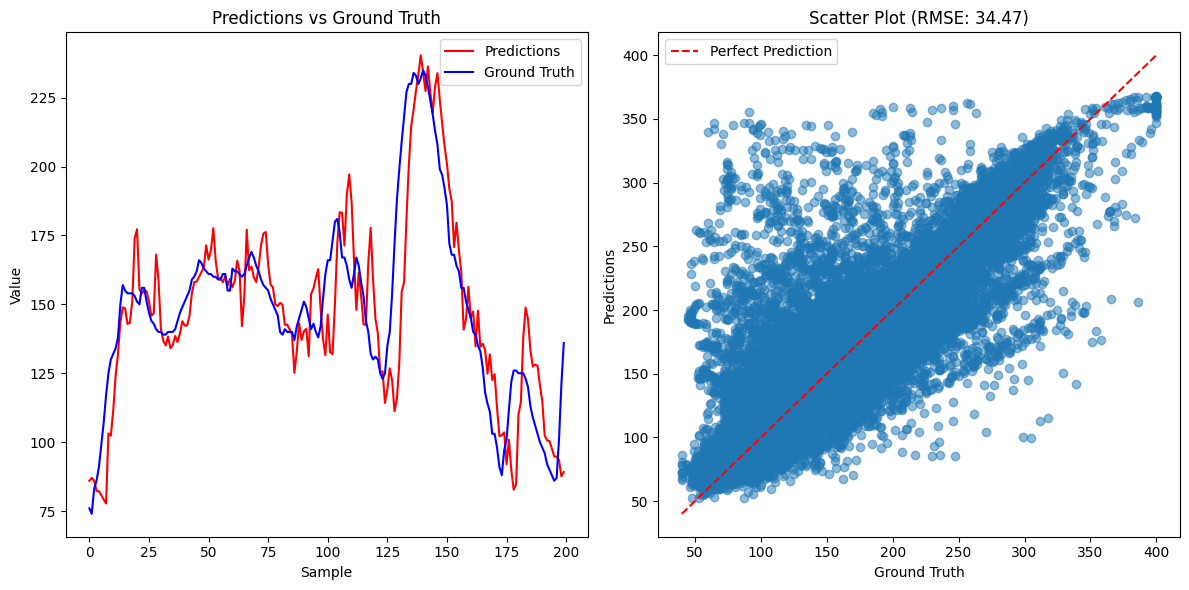

Model saved to /content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/saved_models_original_ohio/model_population_version2_gdrive.pth
RMSE: 34.47
MAE: 20.94
MAPE: 15.53%


In [10]:
# 4. Set hyperparameters
past_sequence_length = 12
future_offset = 6
batch_size = 64
max_interval_minutes = 30
test_eval = []

# Evaluate on test data
metrics = evaluate_and_save_metrics_population(
    model=model,
    test_file_path=population_splits['test'],
    save_dir=os.path.join(cur_dir, 'evaluation_metrics'),
    past_sequence_length=past_sequence_length,
    future_offset=future_offset,
    batch_size=batch_size,
    max_interval_minutes=max_interval_minutes
)

# Save the trained model
save_model(model, 'population_version2_gdrive', save_dir=os.path.join(cur_dir, 'saved_models_original_ohio'))

# evaluation on whole test set
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"MAE: {metrics['mae']:.2f}")
print(f"MAPE: {metrics['mape']:.2f}%")

In [12]:
def load_model(test_file_path, model_class=TransformerEncoder, save_dir='saved_models'):
    # Extract the base filename from the test file path
    test_file_name = os.path.splitext(os.path.basename(test_file_path))[0]
    model_path = os.path.join(save_dir, f'model_{test_file_name}.pth')

    model = TransformerEncoder_version2(
        past_seq_len=past_sequence_length,
        num_layers=1,
        d_model=512,
        nhead=4,
        input_dim=1,
        dropout=0.2
    )

    # Load the saved weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    print(f"Model loaded from {model_path}")
    return model

<ipython-input-12-6dcaacbd92c4>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded from /content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/saved_models_original_ohio/model_population_version2_gdrive.pth
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/559-ws-testing.xml
Test file: 559-ws-testing.xml
Root Mean Square Error (RMSE): 19.94
Mean Absolute Error (MAE): 13.87
Mean Absolute Percentage Error (MAPE): 8.91%


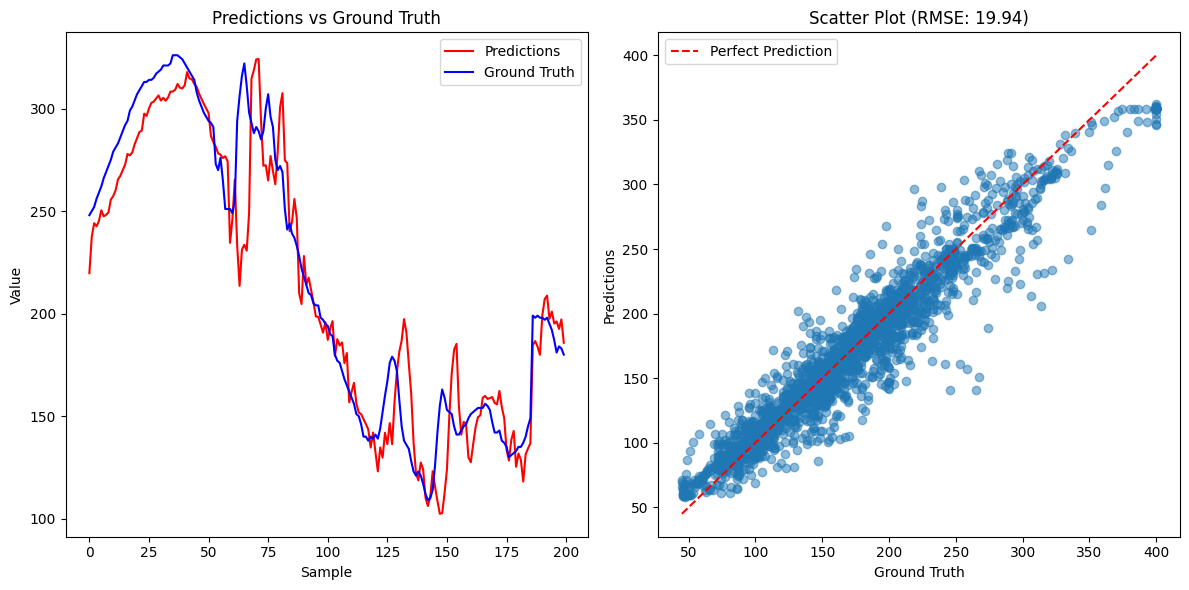

RMSE: 19.94
MAE: 13.87
MAPE: 8.91%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/570-ws-testing.xml
Test file: 570-ws-testing.xml
Root Mean Square Error (RMSE): 17.04
Mean Absolute Error (MAE): 12.15
Mean Absolute Percentage Error (MAPE): 6.00%


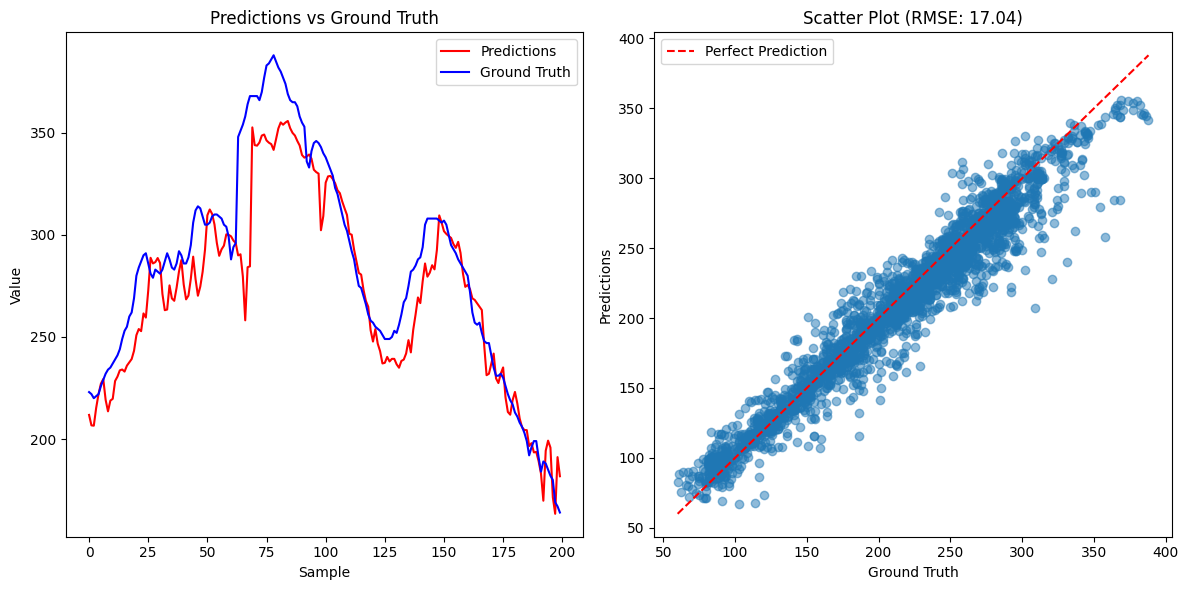

RMSE: 17.04
MAE: 12.15
MAPE: 6.00%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/591-ws-testing.xml
Test file: 591-ws-testing.xml
Root Mean Square Error (RMSE): 21.46
Mean Absolute Error (MAE): 15.48
Mean Absolute Percentage Error (MAPE): 11.92%


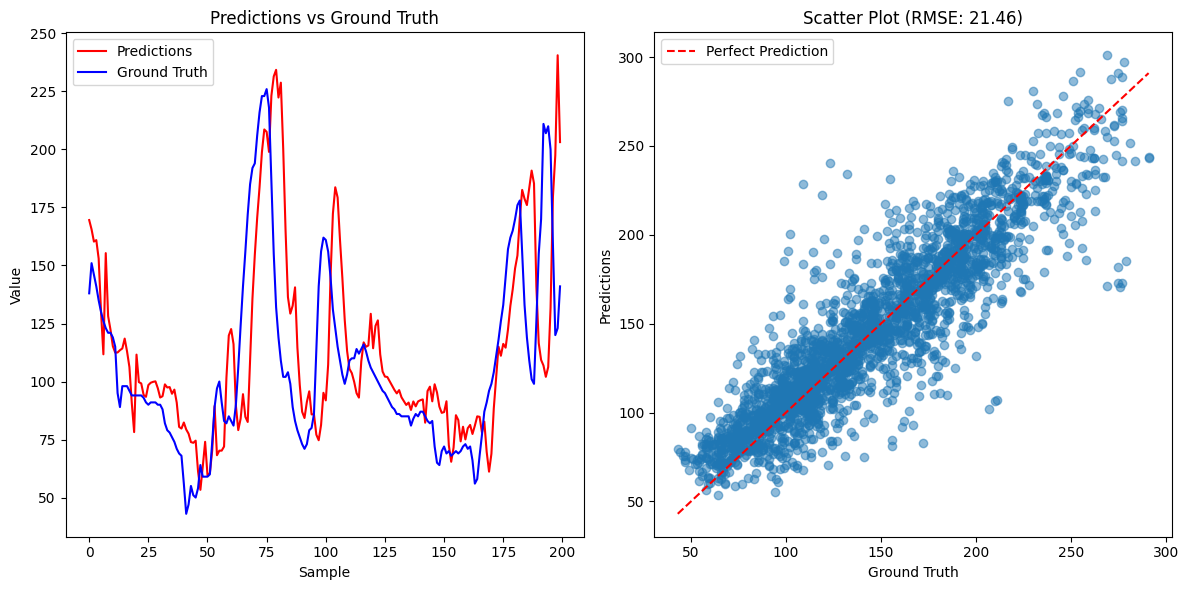

RMSE: 21.46
MAE: 15.48
MAPE: 11.92%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/588-ws-testing.xml
Test file: 588-ws-testing.xml
Root Mean Square Error (RMSE): 18.63
Mean Absolute Error (MAE): 13.45
Mean Absolute Percentage Error (MAPE): 8.07%


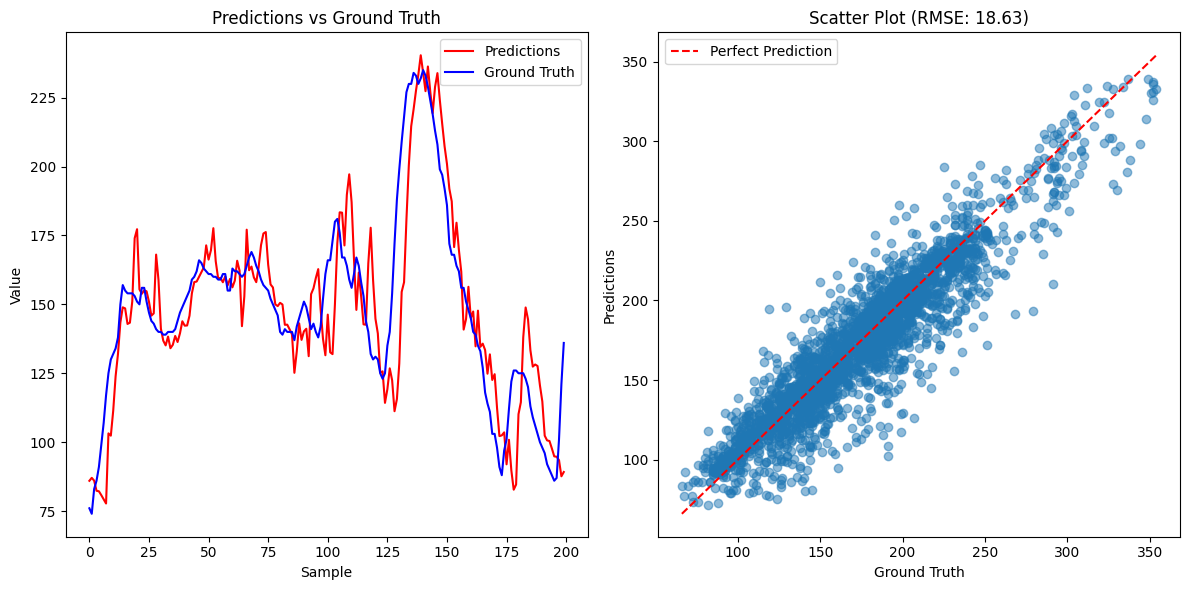

RMSE: 18.63
MAE: 13.45
MAPE: 8.07%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/563-ws-testing.xml
Test file: 563-ws-testing.xml
Root Mean Square Error (RMSE): 18.29
Mean Absolute Error (MAE): 12.86
Mean Absolute Percentage Error (MAPE): 8.12%


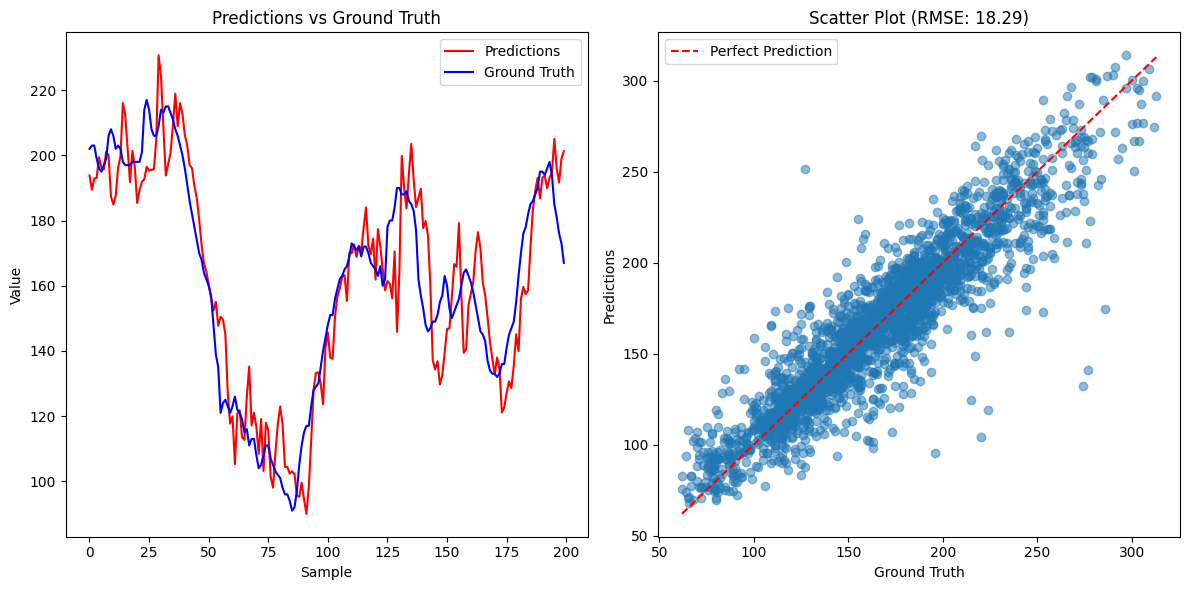

RMSE: 18.29
MAE: 12.86
MAPE: 8.12%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2018/test/575-ws-testing.xml
Test file: 575-ws-testing.xml
Root Mean Square Error (RMSE): 23.29
Mean Absolute Error (MAE): 15.21
Mean Absolute Percentage Error (MAPE): 11.23%


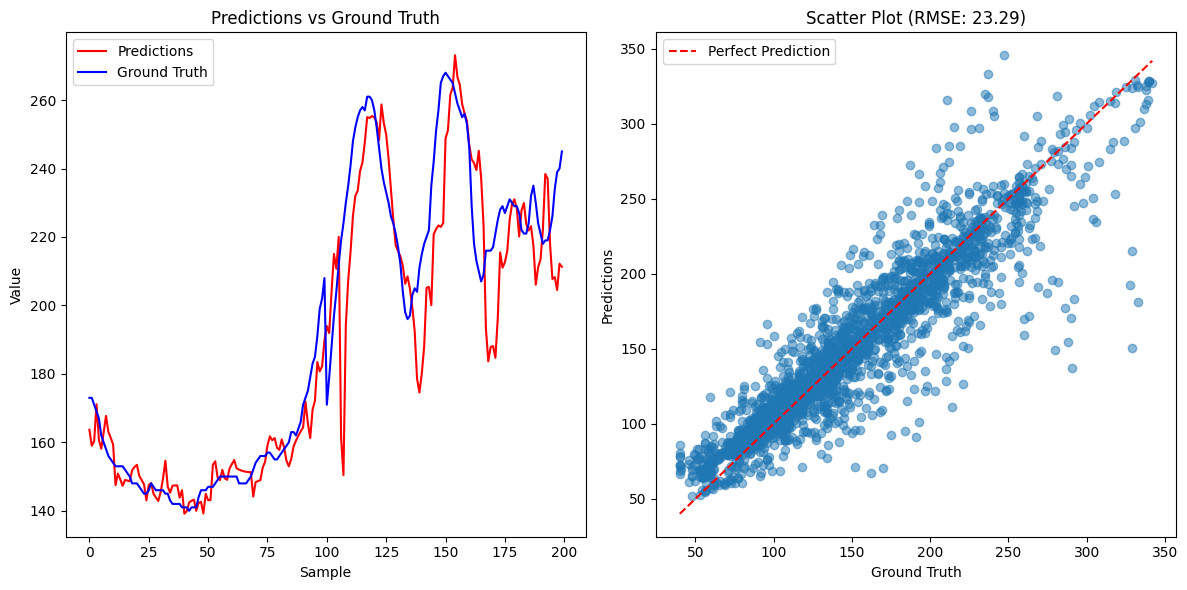

RMSE: 23.29
MAE: 15.21
MAPE: 11.23%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2020/test/584-ws-testing.xml
Test file: 584-ws-testing.xml
Root Mean Square Error (RMSE): 22.66
Mean Absolute Error (MAE): 15.69
Mean Absolute Percentage Error (MAPE): 9.97%


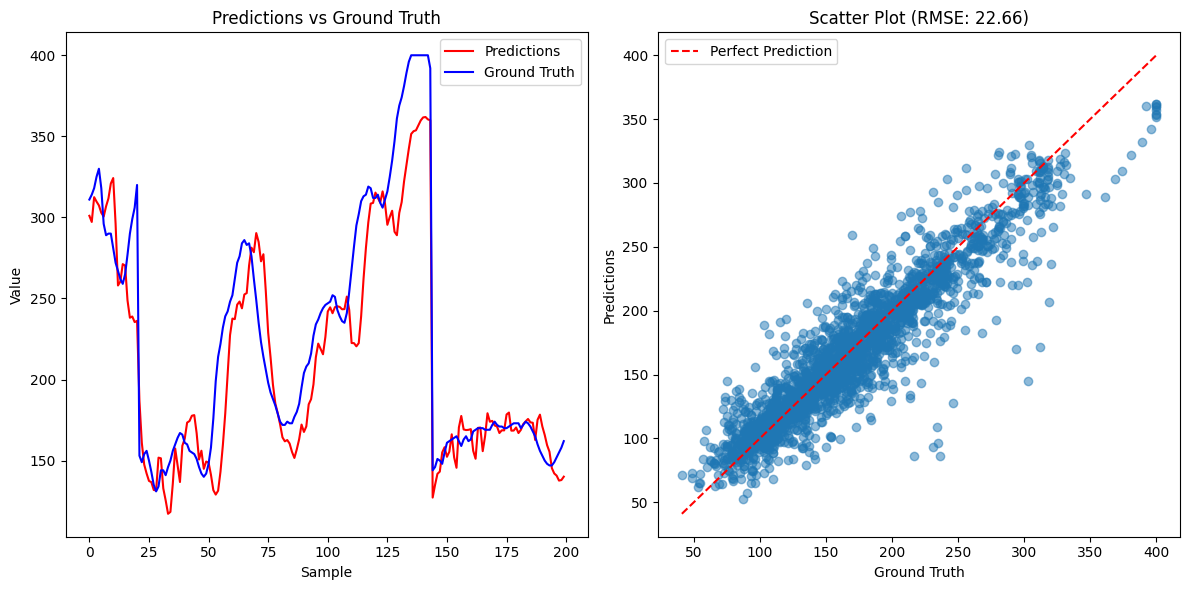

RMSE: 22.66
MAE: 15.69
MAPE: 9.97%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2020/test/540-ws-testing.xml
Test file: 540-ws-testing.xml
Root Mean Square Error (RMSE): 22.76
Mean Absolute Error (MAE): 17.07
Mean Absolute Percentage Error (MAPE): 12.04%


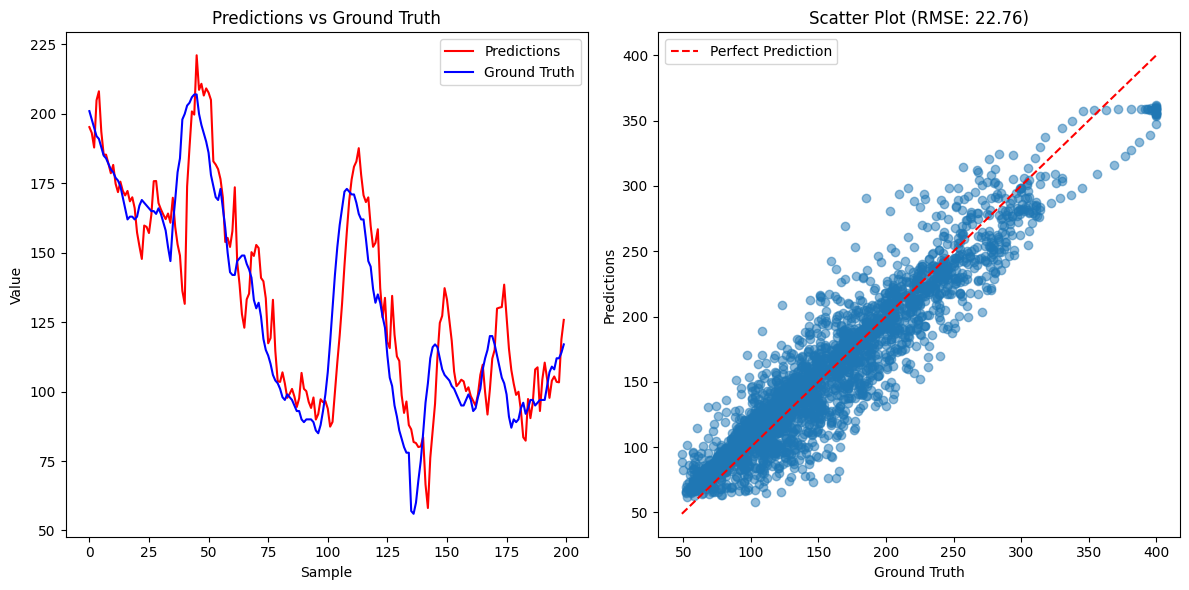

RMSE: 22.76
MAE: 17.07
MAPE: 12.04%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2020/test/544-ws-testing.xml
Test file: 544-ws-testing.xml
Root Mean Square Error (RMSE): 18.28
Mean Absolute Error (MAE): 13.02
Mean Absolute Percentage Error (MAPE): 8.74%


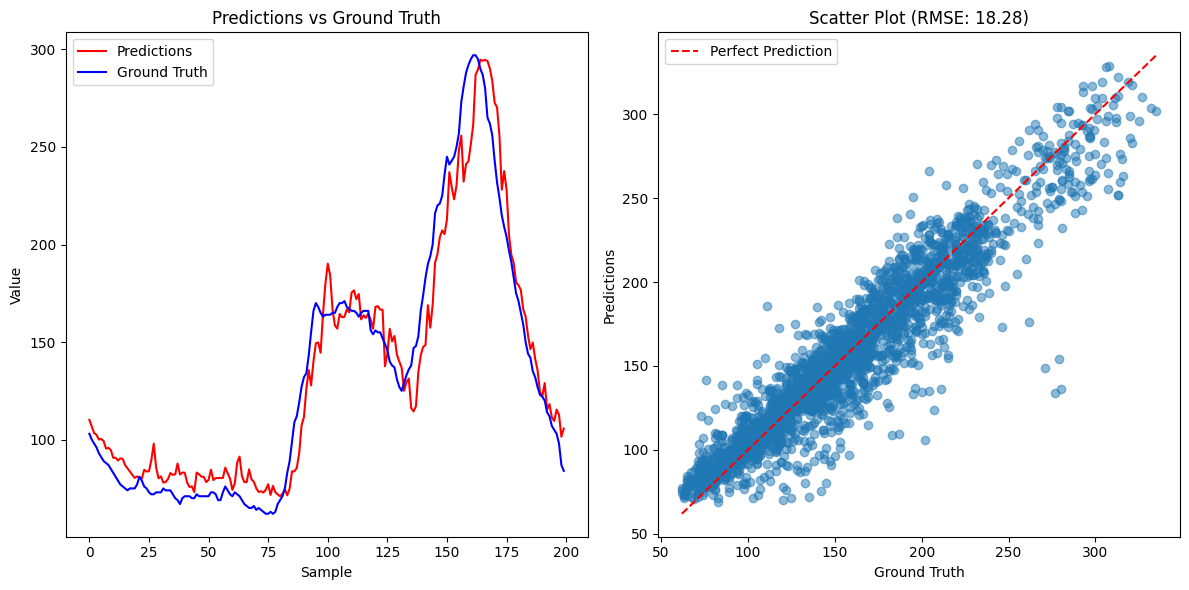

RMSE: 18.28
MAE: 13.02
MAPE: 8.74%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2020/test/567-ws-testing.xml
Test file: 567-ws-testing.xml
Root Mean Square Error (RMSE): 21.60
Mean Absolute Error (MAE): 15.21
Mean Absolute Percentage Error (MAPE): 11.10%


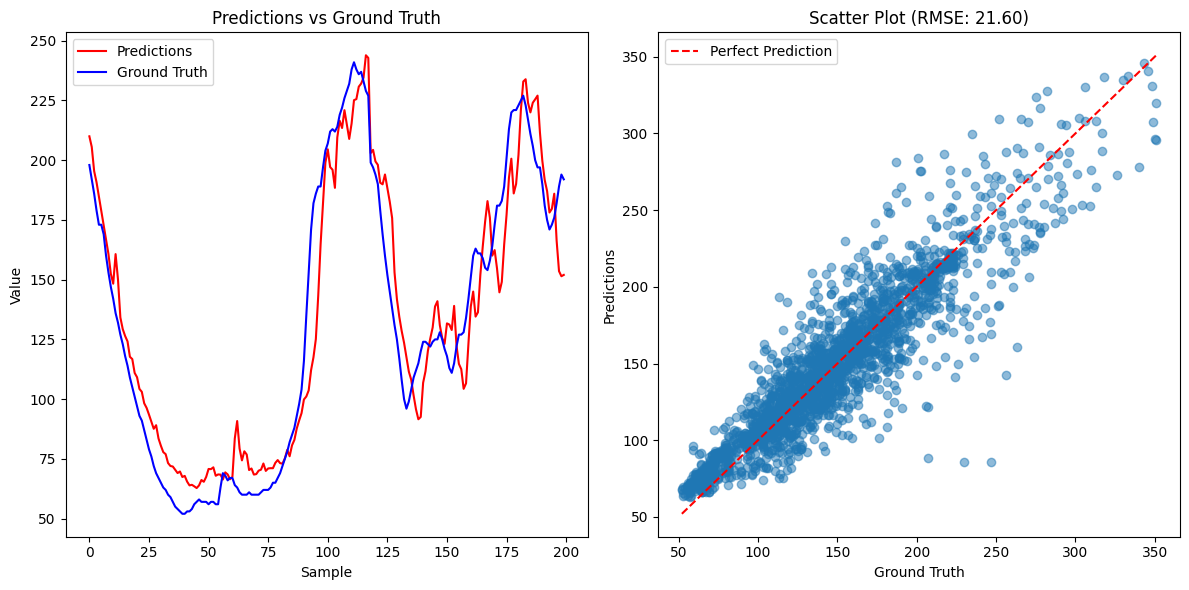

RMSE: 21.60
MAE: 15.21
MAPE: 11.10%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2020/test/596-ws-testing.xml
Test file: 596-ws-testing.xml
Root Mean Square Error (RMSE): 17.21
Mean Absolute Error (MAE): 12.31
Mean Absolute Percentage Error (MAPE): 9.19%


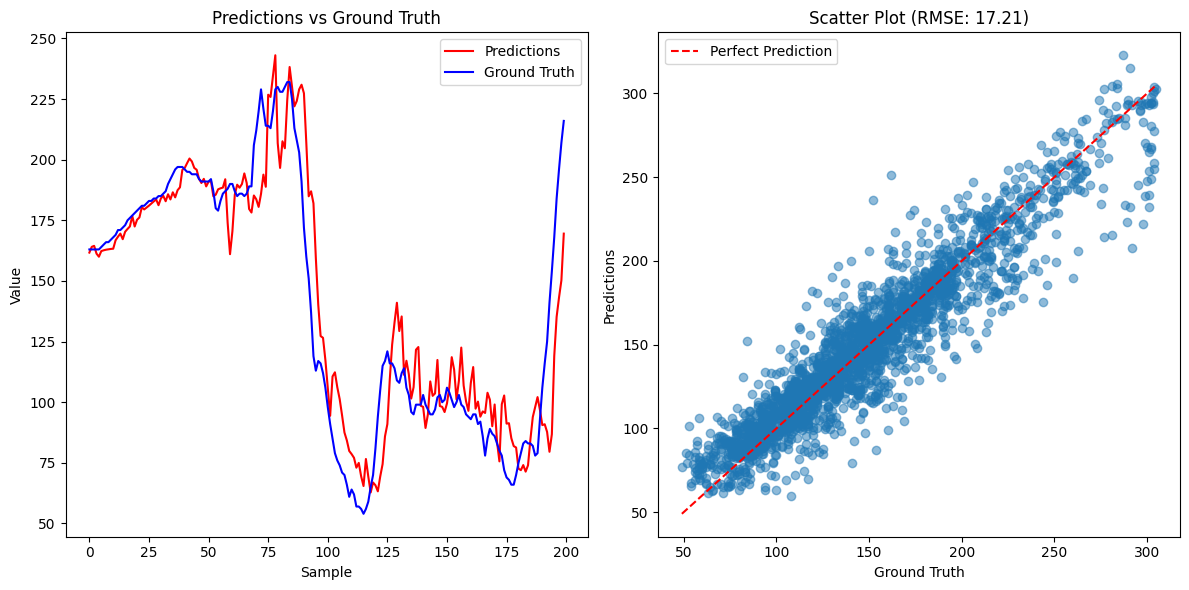

RMSE: 17.21
MAE: 12.31
MAPE: 9.19%
/content/drive/Shareddrives/Yanjun/ReproGenBG/ReproGenBG_ML4H/GlucoseTransformer/./OhioT1DM 2020/2020/test/552-ws-testing.xml
Test file: 552-ws-testing.xml
Root Mean Square Error (RMSE): 16.63
Mean Absolute Error (MAE): 12.67
Mean Absolute Percentage Error (MAPE): 10.01%


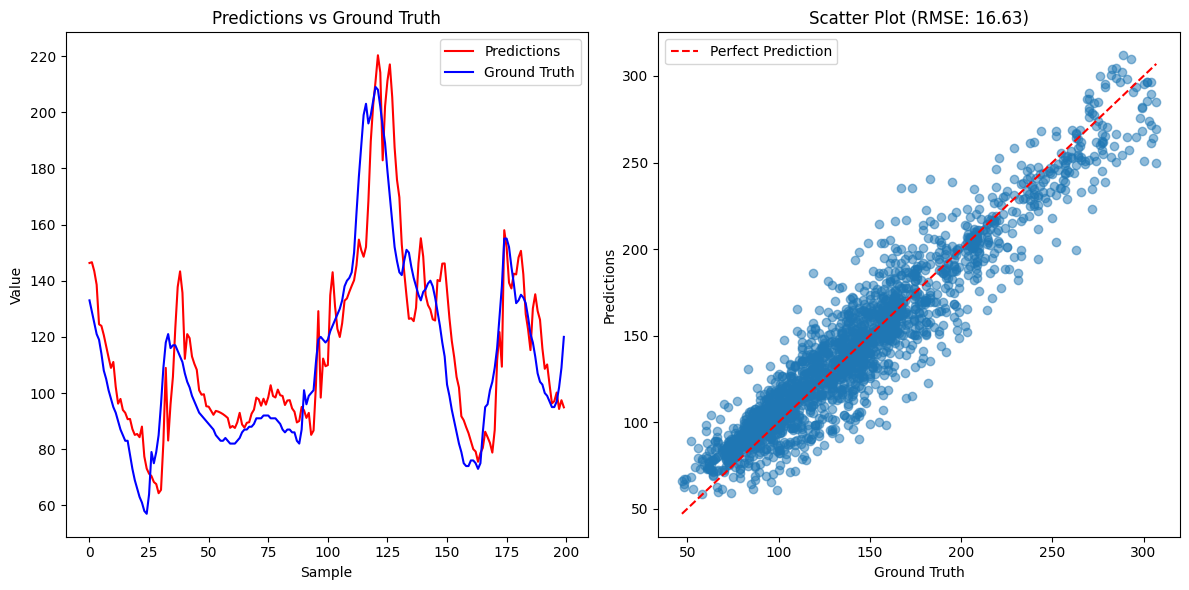

RMSE: 16.63
MAE: 12.67
MAPE: 10.01%


In [13]:
# 4. Set hyperparameters
past_sequence_length = 12
future_offset = 6
batch_size = 64
max_interval_minutes = 30
test_eval = []

# Load the saved model
model = load_model('population_version2_gdrive',  save_dir=os.path.join(cur_dir, 'saved_models_original_ohio'))

for test in population_splits['test']:
    print(test)
    # Evaluate on test data individually
    metrics = evaluate_and_save_metrics(
        model=model,
        test_file_path=test,
        save_dir=os.path.join(cur_dir, 'evaluation_metrics'),
        past_sequence_length=past_sequence_length,
        future_offset=future_offset,
        batch_size=batch_size,
        max_interval_minutes=max_interval_minutes
    )

    id = test.split('/')[-1].split('-')[0]
    test_eval.append([id, round(metrics['rmse'], 2), round(metrics['mae'], 2), round(metrics['mape'], 2)])

    # print(f"\nResults for population model:")
    print(f"RMSE: {metrics['rmse']:.2f}")
    print(f"MAE: {metrics['mae']:.2f}")
    print(f"MAPE: {metrics['mape']:.2f}%")

In [16]:
print(test_eval)
df = pd.DataFrame(test_eval, columns=['test patient', 'RMSE', 'MAE', 'MAPE'])
df.to_csv(os.path.join(cur_dir,'./evaluation_metrics/individual_test_eval_gdrive.csv'), index=False)

[['559', 19.94, 13.87, 8.91], ['570', 17.04, 12.15, 6.0], ['591', 21.46, 15.48, 11.92], ['588', 18.63, 13.45, 8.07], ['563', 18.29, 12.86, 8.12], ['575', 23.29, 15.21, 11.23], ['584', 22.66, 15.69, 9.97], ['540', 22.76, 17.07, 12.04], ['544', 18.28, 13.02, 8.74], ['567', 21.6, 15.21, 11.1], ['596', 17.21, 12.31, 9.19], ['552', 16.63, 12.67, 10.01]]


## Leave-one-out

In [ ]:
# Example usage
# 1. Set up paths and get file lists
folder_path_train_2018 = f"./OhioT1DM 2020/2018/train"
folder_path_train_2020 = "./OhioT1DM 2020/2020/train"
train_files_2018 = [f for f in os.listdir(folder_path_train_2018) if f.endswith('.xml')]
train_files_2020 = [f for f in os.listdir(folder_path_train_2020) if f.endswith('.xml')]

# 2. Create LOOCV splits
loocv_splits = create_loocv_splits(
    folder_path_train_2018,
    folder_path_train_2020,
    train_files_2018,
    train_files_2020
)

# 3. Initialize model
# model = TransformerEncoder(
#     num_layers=3,
#     d_model=64,
#     nhead=4,
#     input_dim=1,
#     dim_feedforward=256,
#     dropout=0.1
# )

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 4. Set hyperparameters
past_sequence_length = 12
future_offset = 6
batch_size = 64
max_interval_minutes = 30

# Get the items starting from fold9

fold_items = dict(list(loocv_splits.items())[1:])

# 5. Train and evaluate for each fold
for fold_name, fold_data in fold_items.items():
    model = TransformerEncoder(
        num_layers=1,
        d_model=512,
        nhead=4,
        input_dim=1,
        dim_feedforward=256,
        dropout=0.2
    )
    model = model.to(device)
    print(f"\nProcessing {fold_name}...")

    # Load and process training data
    train_dfs = []
    for train_file in fold_data['train']:
        df = load_ohio_series_train(train_file, "glucose_level", "value")
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        train_dfs.append(df)

    # Create datasets
    train_series_list = []
    for df in train_dfs:
        series_list = split_into_continuous_series(df, past_sequence_length, future_offset, max_interval_minutes)
        train_series_list.extend(series_list)

    train_dataset, val_dataset = create_train_val_datasets(
        train_series_list,
        train_ratio=0.8,
        past_seq_len=past_sequence_length,
        future_offset=future_offset
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Train model
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=200,
        learning_rate=1e-3
    )

    # Evaluate on test data
    metrics = evaluate_and_save_metrics(
        model=model,
        test_file_path=fold_data['test'],
        save_dir='evaluation_metrics',
        past_sequence_length=past_sequence_length,
        future_offset=future_offset,
        batch_size=batch_size,
        max_interval_minutes=max_interval_minutes
    )

    # Save the trained model
    save_model(model, fold_data['test'][-19:], save_dir='saved_models_original_ohio')

    print(f"\nResults for {fold_name}:")
    print(f"RMSE: {metrics['rmse']:.2f}")
    print(f"MAE: {metrics['mae']:.2f}")
    print(f"MAPE: {metrics['mape']:.2f}%")

In [ ]:
fold_data['test'][-19:]

In [ ]:
save_model(model, fold_data['test'][-19:], save_dir='saved_models_original_ohio')

print(f"\nResults for {fold_name}:")
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"MAE: {metrics['mae']:.2f}")
print(f"MAPE: {metrics['mape']:.2f}%")

In [ ]:
# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")

In [ ]:
# Save model after training each fold
def save_model(model, fold_name, save_dir='saved_models'):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f'model_{fold_name}.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

# Load model for evaluation
def load_model(fold_name, model_class=TransformerEncoder, save_dir='saved_models'):
    model_path = os.path.join(save_dir, f'model_{fold_name}.pth')

    # Initialize a new model with the same architecture
    model = model_class(
        num_layers=3,
        d_model=64,
        nhead=4,
        input_dim=1,
        dim_feedforward=256,
        dropout=0.1
    )

    # Load the saved weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    print(f"Model loaded from {model_path}")
    return model

In [ ]:
fold_name

In [ ]:
# Example usage
# 1. Set up paths and get file lists
folder_path_train_2018 = "/Users/baiyinglu/Desktop/AugmentedHealthLab/T1DEXI_Apr52024/try/OhioT1DM/2018/train"
folder_path_train_2020 = "/Users/baiyinglu/Desktop/AugmentedHealthLab/T1DEXI_Apr52024/try/OhioT1DM/2020/train"
train_files_2018 = [f for f in os.listdir(folder_path_train_2018) if f.endswith('.xml')]
train_files_2020 = [f for f in os.listdir(folder_path_train_2020) if f.endswith('.xml')]

# 2. Create LOOCV splits
loocv_splits = create_loocv_splits(
    folder_path_train_2018,
    folder_path_train_2020,
    train_files_2018,
    train_files_2020
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# 4. Set hyperparameters
past_sequence_length = 7
future_offset = 6
batch_size = 32
max_interval_minutes = 30

# Get the items starting from fold9
starting_fold = 9

In [ ]:
# For a specific fold
fold_name = 'fold9'
fold_data = loocv_splits[fold_name]

# Load the saved model
model = load_model(fold_name)

metrics = evaluate_and_save_metrics(
    model=model,
    test_file_path=fold_data['test'],
    save_dir='evaluation_metrics',
    past_sequence_length=past_sequence_length,
    future_offset=future_offset,
    batch_size=batch_size,
    max_interval_minutes=max_interval_minutes
)

print(f"\nResults for {fold_name}:")
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"MAE: {metrics['mae']:.2f}")
print(f"MAPE: {metrics['mape']:.2f}%")